In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy

# Define paths
train_images_dir = './images/train_v2'
train_csv_file = './train_ship_segmentations_v2.csv'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-06-10 19:38:14.247356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define hyperparameters
image_size = (768, 768)
batch_size = 1
epochs = 10
need_resize = False
if need_resize:
    image_size = (128, 128) # If reducing time for training is needed

In [3]:
# Preprocess the data
raw_df = pd.read_csv('train_ship_segmentations_v2.csv')
raw_df['EncodedPixels'].fillna('', inplace=True)
df = raw_df.drop_duplicates(subset='ImageId').copy()
df['ships'] = df['EncodedPixels'].apply(lambda x: 0 if x == '' else 1)
df

,ImageId,EncodedPixels,ships
0,00003e153.jpg,,0
1,0001124c7.jpg,,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
8,0001b1832.jpg,,0
...,...,...,...
231718,fffedbb6b.jpg,,0
231719,ffff2aa57.jpg,,0
231720,ffff6e525.jpg,,0
231721,ffffc50b4.jpg,,0


In [4]:
# Remove 95% from empty images
no_ships = df['ships'] == 0
num_rows = no_ships.sum()
rows_to_remove = int(0.95 * num_rows)
np.random.seed(42)
rows_to_remove_indices = np.random.choice(df[no_ships].index, size=rows_to_remove, replace=False)
df.drop(rows_to_remove_indices, inplace=True)
df

,ImageId,EncodedPixels,ships
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,1
18,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,1
22,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,1
...,...,...,...
231694,fff909871.jpg,441057 2 441825 4 442592 7 443360 9 444128 11 ...,1
231701,fffa80c97.jpg,,0
231709,fffcb6464.jpg,222782 4 223550 10 224318 14 225086 14 225854 ...,1
231712,fffd924fb.jpg,110011 5 110779 5 111547 5 112315 5 113083 5 1...,1


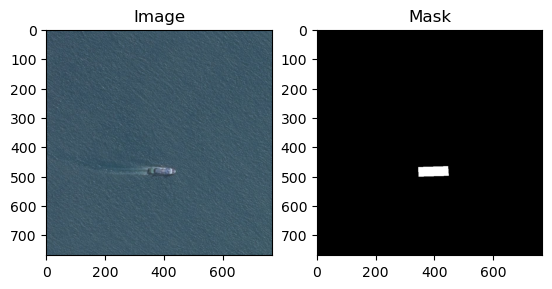

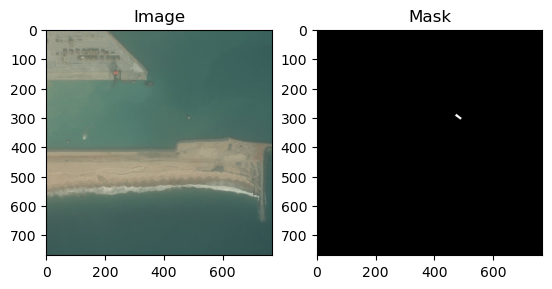

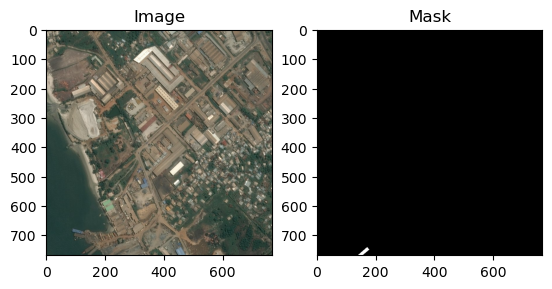

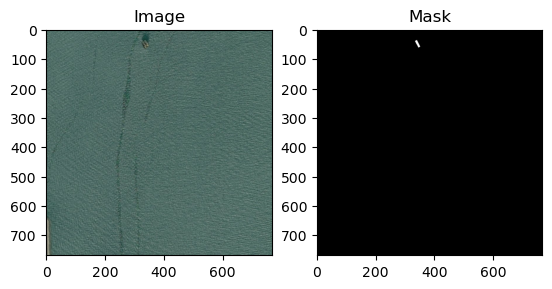

In [5]:
df_to_show = df.head(4)
df_to_show

images = []
masks = []
shape = image_size[0]

for _, row in df_to_show.iterrows():
    image_path = os.path.join(train_images_dir, row['ImageId'])
    mask = np.zeros(shape * shape, dtype=np.uint8)
    if not os.path.exists(image_path):
        continue  # Skip if image file does not exist
    if row['EncodedPixels'] != '':
        pixels = [int(x) for x in row['EncodedPixels'].split()]
        coordinates = [(pixels[i], pixels[i + 1]) for i in range(0, len(pixels), 2)]
        for coord in coordinates:
            start, length = coord
            mask[start:start + length] = 1
    mask = mask.reshape(shape,shape).T

    image = load_img(image_path)
    image = img_to_array(image)
    images.append(image)
    masks.append(mask)

    plt.subplot(1, 2, 1)
    plt.imshow(image.astype(np.uint8))
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.show()

images = np.array(images)
masks = np.array(masks)

In [6]:
df = df.head(40)
df

,ImageId,EncodedPixels,ships
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,1
18,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,1
22,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,1
24,000532683.jpg,458957 14 459725 14 460493 14 461261 14 462029...,1
26,00053c6ba.jpg,565382 3 566144 9 566909 12 567677 13 568445 1...,1
29,0005d01c8.jpg,56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...,1
31,0005d6d95.jpg,265143 1 265910 4 266678 5 267445 7 268212 10 ...,1
32,0006c52e8.jpg,146366 1 147132 4 147899 5 148666 7 149432 10 ...,1


In [7]:
# Split the data into training and validation sets
df_train_split, df_val_split = train_test_split(df,test_size=0.4,
                                                stratify=df['ships'],
                                                random_state=42)

In [8]:
# Define the UNet model

def unet_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Contracting path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Expanding path
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = layers.concatenate([conv2, up4], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = layers.concatenate([conv1, up5], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
# Create the model
model = unet_model(image_size + (3,))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 768, 768, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 768, 768, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

2023-06-10 19:38:18.391453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Callbacks for controling proccess of training
checkpoint = ModelCheckpoint('./best_model',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
                             #saves best result of training

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8) 
                                   #reduces learning rate when a metric has stopped improving

early_stopping = EarlyStopping(monitor="val_loss", mode="min", 
                               verbose=1,patience=10)
                               #responses for stopping of model when a quality of model has stopped improving

callbacks_list = [checkpoint, reduceLROnPlat, early_stopping] # list of callbacks

In [11]:
# Prepare data generator

class DataGenerator:
    def __init__(self, df, batch_size, image_size, need_resize):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.need_resize = need_resize
        self.datagen = ImageDataGenerator(rescale=1.0/255.0)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def generate(self):
        while True:
            batch_indices = np.random.choice(len(self.df), size=self.batch_size, replace=False)
            batch_df = self.df.iloc[batch_indices]
            images = []
            masks = []

            for _, row in batch_df.iterrows():
                image_path = os.path.join(train_images_dir, row['ImageId'])
                mask = np.zeros(self.image_size)
                if not os.path.exists(image_path):
                    continue  # Skip if image file does not exist
                if row['EncodedPixels'] != '':
                    pixels = [int(x) for x in row['EncodedPixels'].split()]
                    coordinates = [(pixels[i], pixels[i + 1]) for i in range(0, len(pixels), 2)]
                    for coord in coordinates:
                        start, length = coord
                        mask[start:start + length] = 1
                mask = mask.reshape(shape,shape).T

                image = load_img(image_path, target_size=(self.image_size if self.need_resize else (768, 768)))
                image = img_to_array(image)
                images.append(image)
                masks.append(mask)

            images = np.array(images)
            masks = np.array(masks)

            # Apply data augmentation using ImageDataGenerator
            images = self.datagen.flow(images, shuffle=False).next()

            yield images, masks

In [12]:
def dice_score(pred_masks, true_masks, smooth=1e-7):
    intersection = K.sum(pred_masks * true_masks)
    union = K.sum(pred_masks) + K.sum(true_masks)

    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice


def bce_dice_loss(y_pred, y_target):
    # dice loss metric
    return binary_crossentropy(y_target, y_pred) + (1-dice_score(y_pred, y_target))

In [13]:
# Compile the model

model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=bce_dice_loss, metrics=['binary_accuracy', dice_score])

In [14]:
# Create data generator

train_generator = DataGenerator(df_train_split, batch_size, image_size, need_resize).generate()
val_generator = DataGenerator(df_val_split, batch_size, image_size, need_resize).generate()

In [15]:
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=len(df_train_split) // batch_size,
                    validation_data=val_generator,
                    validation_steps=len(df_val_split) // batch_size,
                    callbacks=callbacks_list,
                    verbose=1)
model.save("./full_model")

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.1313 - binary_accuracy: 0.9584 - dice_score: 0.7084 
Epoch 1: val_loss improved from inf to 0.00000, saving model to ./best_model


INFO:tensorflow:Assets written to: ./best_model/assets


INFO:tensorflow:Assets written to: ./best_model/assets


24/24 [==============================] - 476s 20s/step - loss: 1.1313 - binary_accuracy: 0.9584 - dice_score: 0.7084 - val_loss: 0.0000e+00 - val_binary_accuracy: 1.0000 - val_dice_score: 1.0000 - lr: 0.0010
Epoch 2/10
10/24 [===========>..................] - ETA: 3:57 - loss: 0.0000e+00 - binary_accuracy: 1.0000 - dice_score: 1.0000